## Data

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import imblearn
import collections
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from imblearn.over_sampling import ADASYN

In [3]:
df = pd.read_csv('/Users/claudiajovellar/code/AlcaRmsp/the_laundromat/raw_data/data.csv')

df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [4]:
df['errorBalanceOrig']=df['newBalanceOrig'] + df['amount'] - df['oldBalanceOrig']
df['errorBalanceDest']=df['newBalanceDest'] + df['amount'] - df['oldBalanceDest']

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Check unique values for streets (2)
print(f"The unique values for 'type' are {df.type.unique()}")

# Instantiate the OneHotEncoder
ohe_binary = OneHotEncoder(sparse = False, drop="if_binary") 

# Fit encoder
ohe_binary.fit(df[['type']]) 

# Display the detected categories
print(f"The categories detected by the OneHotEncoder are {ohe_binary.categories_}")

# Display the generated names
print(f"The column names for the encoded values are {ohe_binary.get_feature_names_out()}")

# Transform the current "Street" column
df[ohe_binary.get_feature_names_out()] = ohe_binary.transform(df[['type']])

# Drop the column "Street" which has been encoded
df.drop(columns = ["type"], inplace = True)

The unique values for 'type' are ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


/Users/claudiajovellar/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The categories detected by the OneHotEncoder are [array(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
      dtype=object)]
The column names for the encoded values are ['type_CASH_IN' 'type_CASH_OUT' 'type_DEBIT' 'type_PAYMENT'
 'type_TRANSFER']


In [6]:
from sklearn.preprocessing import LabelEncoder
# create a label encoder object
le = LabelEncoder()

# apply the label encoder to non-numeric columns
df['nameOrig'] = le.fit_transform(df['nameOrig'])
df['nameDest'] = le.fit_transform(df['nameDest'])

In [12]:
dffraud = df[df.isFraud == 1]

In [19]:
dffraud.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2,1,181.0,1002156,181.0,0.0,439685,0.0,0.0,1,0,0.0,181.0,0.0,0.0,0.0,0.0,1.0
3,1,181.0,5828262,181.0,0.0,391696,21182.0,0.0,1,0,0.0,-21001.0,0.0,1.0,0.0,0.0,0.0
251,1,2806.0,1379875,2806.0,0.0,563886,0.0,0.0,1,0,0.0,2806.0,0.0,0.0,0.0,0.0,1.0
252,1,2806.0,3619815,2806.0,0.0,2134,26202.0,0.0,1,0,0.0,-23396.0,0.0,1.0,0.0,0.0,0.0
680,1,20128.0,1232211,20128.0,0.0,251089,0.0,0.0,1,0,0.0,20128.0,0.0,0.0,0.0,0.0,1.0


In [15]:
dffraud.shape

(8213, 17)

### Split data

In [7]:
# Separate the features and target variable
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Balancing data

### SMOTE - Training Set

([<matplotlib.patches.Wedge at 0x12ad66290>,
 [Text(-1.099990955625572, 0.004460666087110192, 'Not Fraud'),
  Text(1.0999909559371663, -0.004460589247970448, 'Fraud')])

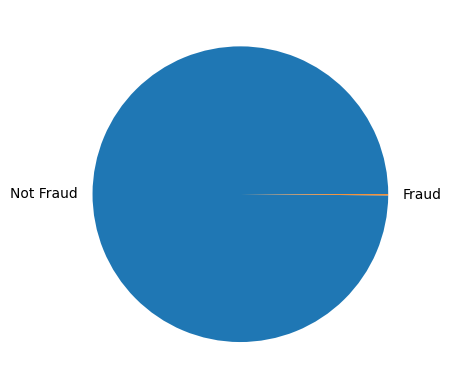

In [9]:
#Check if data is balanced before SMOTE
labels = 'Not Fraud','Fraud'
values=df['isFraud'].value_counts()
fig, ax = plt.subplots()
ax.pie(values, labels=labels)

In [10]:
print(imblearn.__version__)

0.9.1


In [11]:
# summarize class distribution
counter = collections.Counter(y)
print(counter)

Counter({0: 6354407, 1: 8213})


In [12]:
X_train.shape, y_train.shape

((4453834, 16), (4453834,))

In [13]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [14]:
X_resampled.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,202,26771.98,2487575,27521.00,54292.98,18776,7175503.03,7148731.05,0,53543.96,0.00,1.0,0.0,0.0,0.0,0.0
1,36,344879.65,1909142,0.00,0.00,125492,3731846.57,4076726.22,0,344879.65,689759.30,0.0,1.0,0.0,0.0,0.0
2,20,1862607.84,4401349,0.00,0.00,317835,3329828.01,4913631.27,0,1862607.84,3446411.10,0.0,0.0,0.0,0.0,1.0
3,354,37739.35,5203756,66684.93,28945.58,604220,0.00,0.00,0,0.00,37739.35,0.0,0.0,0.0,1.0,0.0
4,38,376055.13,2337985,22501.00,0.00,26843,182350.43,558405.55,0,353554.13,752110.25,0.0,1.0,0.0,0.0,0.0


In [15]:
X_resampled.shape, y_resampled.shape

((8896112, 16), (8896112,))

In [16]:
pd.DataFrame(y_resampled)

,isFraud
0,0
1,0
2,0
3,0
4,0
...,...
8896107,1
8896108,1
8896109,1
8896110,1


In [17]:
X_resampled['isFraud'] = y_resampled

([<matplotlib.patches.Wedge at 0x14c949db0>,
 [Text(6.735557395310444e-17, 1.1, 'Not Fraud'),
  Text(-2.0206672185931328e-16, -1.1, 'Fraud')])

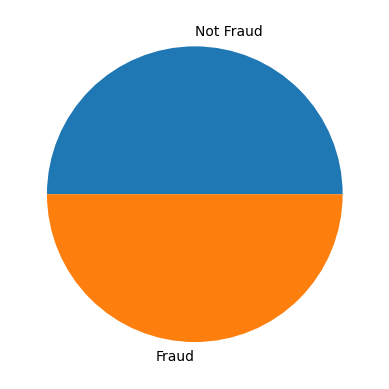

In [18]:
#Check if data is balanced after SMOTE balancing
labels = 'Not Fraud','Fraud'
values= X_resampled['isFraud'].value_counts()
fig, ax = plt.subplots()
ax.pie(values, labels=labels)

([<matplotlib.patches.Wedge at 0x124a86b30>,
 [Text(6.735557395310444e-17, 1.1, 'Not Fraud'),
  Text(-2.0206672185931328e-16, -1.1, 'Fraud')])

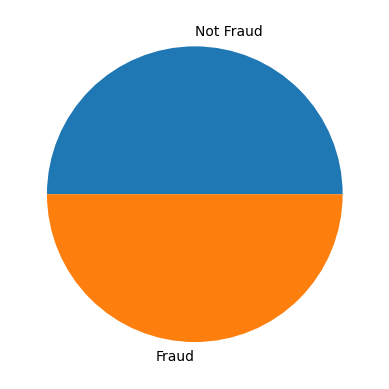

In [19]:
#Check if data is balanced after SMOTE balancing
import matplotlib.pyplot as plt
labels = 'Not Fraud','Fraud'
values=X_resampled['isFraud'].value_counts()
fig, ax = plt.subplots()
ax.pie(values, labels=labels)

#### Getting a sample of the training data 

In [20]:
fraud = X_resampled[X_resampled.isFraud == 1].sample(100000)
fraud.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
8740263,295,3.777543e+06,90008,3.777543e+06,0.0,310803,23962.946992,3.801506e+06,0,0.0,7.555085e+06,0.0,1.0,0.0,0.0,0.0,1
7351144,345,1.402863e+06,731032,1.402863e+06,0.0,376499,0.000000,0.000000e+00,0,0.0,1.402863e+06,0.0,0.0,0.0,0.0,1.0,1
6486346,542,8.903105e+04,501154,8.903105e+04,0.0,248969,923728.708512,1.012760e+06,0,0.0,1.780621e+05,0.0,1.0,0.0,0.0,0.0,1
6279774,236,4.544690e+06,1558796,4.544690e+06,0.0,158785,40522.715208,4.585212e+06,0,0.0,9.089379e+06,0.0,1.0,0.0,0.0,0.0,1
5995637,528,7.118095e+04,2636350,7.118095e+04,0.0,75781,0.000000,0.000000e+00,0,0.0,7.118095e+04,0.0,0.0,0.0,0.0,1.0,1


In [21]:
notfraud = X_resampled[X_resampled.isFraud == 0].sample(100000)

In [22]:
data_new = pd.concat([fraud, notfraud], axis=0)
data_new

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
8740263,295,3.777543e+06,90008,3.777543e+06,0.00,310803,2.396295e+04,3.801506e+06,0,0.00,7.555085e+06,0.0,1.0,0.0,0.0,0.0,1
7351144,345,1.402863e+06,731032,1.402863e+06,0.00,376499,0.000000e+00,0.000000e+00,0,0.00,1.402863e+06,0.0,0.0,0.0,0.0,1.0,1
6486346,542,8.903105e+04,501154,8.903105e+04,0.00,248969,9.237287e+05,1.012760e+06,0,0.00,1.780621e+05,0.0,1.0,0.0,0.0,0.0,1
6279774,236,4.544690e+06,1558796,4.544690e+06,0.00,158785,4.052272e+04,4.585212e+06,0,0.00,9.089379e+06,0.0,1.0,0.0,0.0,0.0,1
5995637,528,7.118095e+04,2636350,7.118095e+04,0.00,75781,0.000000e+00,0.000000e+00,0,0.00,7.118095e+04,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93029,188,1.193504e+04,2051670,1.194900e+04,13.96,1988295,0.000000e+00,0.000000e+00,0,0.00,1.193504e+04,0.0,0.0,0.0,1.0,0.0,0
2614193,262,1.179766e+05,3547735,0.000000e+00,0.00,540547,9.213339e+05,1.039311e+06,0,117976.64,2.359533e+05,0.0,0.0,0.0,0.0,1.0,0
2362161,514,2.033946e+05,3597139,0.000000e+00,0.00,228904,3.297669e+06,3.501063e+06,0,203394.61,4.067892e+05,0.0,1.0,0.0,0.0,0.0,0
3287942,20,8.063450e+03,3537952,1.657000e+03,0.00,1300241,0.000000e+00,0.000000e+00,0,6406.45,8.063450e+03,0.0,0.0,0.0,1.0,0.0,0


### SMOTE - Test test 50/50

In [23]:
Xtest_resampled50, ytest_resampled50 = SMOTE().fit_resample(X_test, y_test)

In [24]:
Xtest_resampled50.shape, ytest_resampled50.shape

((3812702, 16), (3812702,))

In [25]:
Xtest_resampled50.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,278,330218.42,5144186,20866.00,351084.42,523341,452419.57,122201.15,0,660436.84,-5.820766e-11,1.0,0.0,0.0,0.0,0.0
1,15,11647.08,868156,30370.00,18722.92,1849210,0.00,0.00,0,0.00,1.164708e+04,0.0,0.0,0.0,1.0,0.0
2,10,152264.21,2453021,106589.00,258853.21,179836,201303.01,49038.80,0,304528.42,0.000000e+00,1.0,0.0,0.0,0.0,0.0
3,403,1551760.63,4162339,0.00,0.00,167013,3198359.45,4750120.08,0,1551760.63,3.103521e+06,0.0,0.0,0.0,0.0,1.0
4,206,78172.30,5740614,2921331.58,2999503.88,27202,415821.90,337649.60,0,156344.60,-5.820766e-11,1.0,0.0,0.0,0.0,0.0


In [26]:
Xtest_resampled50['isFraud'] = ytest_resampled50

### SMOTE - Test 70/30

In [27]:
Xtest_resampled70, ytest_resampled30 = SMOTE(sampling_strategy = 0.3).fit_resample(X_test, y_test)

In [28]:
Xtest_resampled70.shape, ytest_resampled30.shape

((2478256, 16), (2478256,))

In [29]:
Xtest_resampled70.head()

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,278,330218.42,5144186,20866.00,351084.42,523341,452419.57,122201.15,0,660436.84,-5.820766e-11,1.0,0.0,0.0,0.0,0.0
1,15,11647.08,868156,30370.00,18722.92,1849210,0.00,0.00,0,0.00,1.164708e+04,0.0,0.0,0.0,1.0,0.0
2,10,152264.21,2453021,106589.00,258853.21,179836,201303.01,49038.80,0,304528.42,0.000000e+00,1.0,0.0,0.0,0.0,0.0
3,403,1551760.63,4162339,0.00,0.00,167013,3198359.45,4750120.08,0,1551760.63,3.103521e+06,0.0,0.0,0.0,0.0,1.0
4,206,78172.30,5740614,2921331.58,2999503.88,27202,415821.90,337649.60,0,156344.60,-5.820766e-11,1.0,0.0,0.0,0.0,0.0


In [30]:
Xtest_resampled70['isFraud'] = ytest_resampled30

### 50/50 Getting a sample of the test data 

In [31]:
fraud_test = Xtest_resampled50[Xtest_resampled50.isFraud == 1].sample(17500)

In [32]:
notfraud_test = Xtest_resampled50[Xtest_resampled50.isFraud == 0].sample(17500)

In [33]:
data_new_test = pd.concat([fraud_test, notfraud_test], axis=0)
data_new_test

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
2494625,279,1.118239e+06,1805131,1.118239e+06,0.00,446341,0.000000e+00,0.000000e+00,0,0.00,1.118239e+06,0.0,0.0,0.0,0.0,1.0,1
2351921,301,5.132665e+06,4470190,5.132665e+06,0.00,92892,0.000000e+00,0.000000e+00,0,0.00,5.132665e+06,0.0,0.0,0.0,0.0,1.0,1
2889363,328,3.028501e+05,2617402,3.028501e+05,0.00,248561,2.427778e+05,5.456279e+05,0,0.00,6.057003e+05,0.0,1.0,0.0,0.0,0.0,1
2082807,429,1.255073e+06,3989547,1.255073e+06,0.00,557365,1.377940e+05,1.392867e+06,0,0.00,2.510146e+06,0.0,1.0,0.0,0.0,0.0,1
2467234,363,2.985994e+05,3058181,2.985994e+05,0.00,136008,0.000000e+00,0.000000e+00,0,0.00,2.985994e+05,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883680,236,2.021091e+05,3220048,5.053254e+05,707434.50,30979,3.285775e+06,3.083666e+06,0,404218.14,-4.656613e-10,1.0,0.0,0.0,0.0,0.0,0
694061,303,1.000329e+05,126658,0.000000e+00,0.00,244917,4.088102e+05,5.088431e+05,0,100032.90,2.000658e+05,0.0,1.0,0.0,0.0,0.0,0
338478,348,2.186818e+05,3461548,9.438000e+03,228119.78,465056,5.707541e+06,6.097489e+06,0,437363.56,6.086295e+05,1.0,0.0,0.0,0.0,0.0,0
704756,353,9.499791e+05,437596,1.775000e+03,0.00,217765,0.000000e+00,9.499791e+05,0,948204.11,1.899958e+06,0.0,0.0,0.0,0.0,1.0,0


In [34]:
X_test_SMOTE50 = data_new_test.drop('isFraud', axis=1)
y_test_SMOTE50 = data_new_test['isFraud']

### 70/30 getting a sample of the data

In [35]:
fraud_test7_3 = Xtest_resampled70[Xtest_resampled70.isFraud == 1].sample(10500)

In [36]:
notfraud_test7_3 = Xtest_resampled70[Xtest_resampled70.isFraud == 0].sample(24500)

In [37]:
data_new_test7_3 = pd.concat([fraud_test7_3, notfraud_test7_3], axis=0)
data_new_test7_3

,step,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
2310101,568,5.551132e+06,6135998,5.551132e+06,0.00,343392,0.000000e+00,0.000000e+00,0,0.00,5.551132e+06,0.0,0.000000,0.0,0.0,1.000000,1
2035113,367,7.038849e+05,4904971,7.038849e+05,0.00,110894,0.000000e+00,0.000000e+00,0,0.00,7.038849e+05,0.0,0.000000,0.0,0.0,1.000000,1
1979409,282,1.628572e+04,339105,1.628572e+04,0.00,42195,1.406711e+07,1.408340e+07,0,0.00,3.257142e+04,0.0,1.000000,0.0,0.0,0.000000,1
2282341,584,9.928844e+06,1507905,9.928844e+06,0.00,428184,6.217345e+05,1.055058e+07,0,0.00,1.985769e+07,0.0,1.000000,0.0,0.0,0.000000,1
2379430,680,7.309132e+04,1502431,7.309132e+04,0.00,259687,9.432801e+04,1.578058e+05,0,0.00,1.365691e+05,0.0,0.888549,0.0,0.0,0.111451,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135753,306,3.373202e+04,2809985,1.042910e+05,70558.98,171248,8.891497e+05,9.228817e+05,0,0.00,6.746403e+04,0.0,1.000000,0.0,0.0,0.000000,0
657444,19,2.710026e+05,652200,0.000000e+00,0.00,181035,2.170452e+06,2.441455e+06,0,271002.63,5.420053e+05,0.0,1.000000,0.0,0.0,0.000000,0
1902116,38,2.049653e+05,2073916,2.060910e+05,1125.71,63580,2.828038e+05,4.877691e+05,0,0.00,4.099306e+05,0.0,1.000000,0.0,0.0,0.000000,0
1217712,35,2.288777e+04,1629014,0.000000e+00,0.00,1572080,0.000000e+00,0.000000e+00,0,22887.77,2.288777e+04,0.0,0.000000,0.0,1.0,0.000000,0


In [38]:
X_test_SMOTE70 = data_new_test7_3.drop('isFraud', axis=1)
y_test_SMOTE30 = data_new_test7_3['isFraud']

## Modelling with SMOTE + RFC

### 50/50 Instantiate the Random Forest Classifier model

In [39]:
X_train1 = data_new.drop('isFraud', axis = 1)
y_train1 = data_new['isFraud']

In [40]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [41]:
#Train the model on the Training Data = X_resampled and y_resampled
model.fit(X_train1, y_train1)

RandomForestClassifier()

In [42]:
y_pred = model.predict(X_test_SMOTE50)

### 70/30 Instantiate the Random Forest Classifier model

In [43]:
y_pred7_3 = model.predict(X_test_SMOTE70)

### 50/50 Score model on test data

In [49]:
# Score the model on the Test data
from sklearn.metrics import recall_score
recall50 = recall_score(y_test_SMOTE50, y_pred)
print("RFC Recall:", recall50)

RFC Recall: 0.9948


In [50]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test_SMOTE50, y_pred)
print('RFC Model accuracy: {0:0.4f}'.format(accuracy_score(y_test_SMOTE50, y_pred)))

RFC Model accuracy: 0.9974


In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_SMOTE50, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[17500     0]
 [   91 17409]]

True Positives(TP) =  17500

True Negatives(TN) =  17409

False Positives(FP) =  0

False Negatives(FN) =  91


<AxesSubplot:>

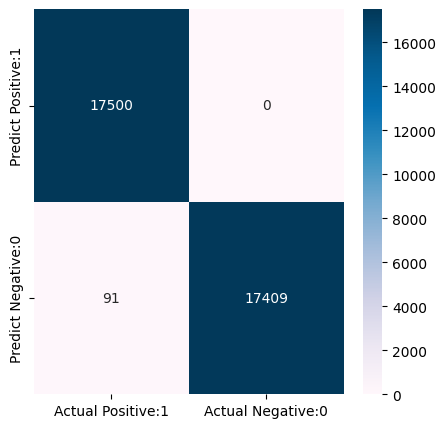

In [52]:
confusion_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

fig, ax = plt.subplots(figsize=(5,5)) 
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap = 'PuBu', ax = ax)

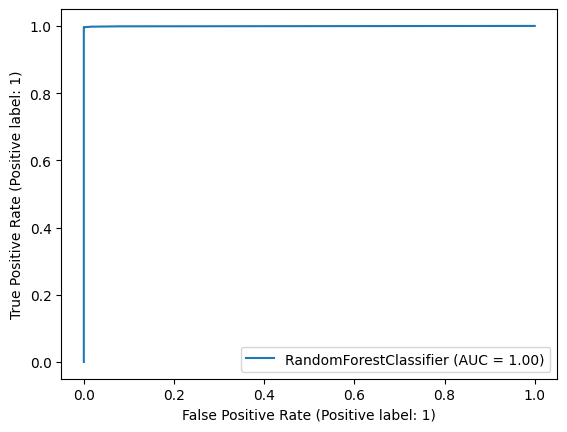

In [53]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test_SMOTE50, y_test_SMOTE50)
plt.show()

### Trying the above model dropping two features

In [ ]:
X_train1_df = X_train1.drop('errorBalanceOrig', axis = 1)
X_train1_df1 = X_train1_df.drop('newBalanceOrig', axis = 1)
X_train1_df1.head()

In [ ]:
model.fit(X_train1_df1, y_train1)

In [ ]:
X_test_df = X_test_SMOTE50.drop('errorBalanceOrig', axis = 1)
X_test_df1 = X_test_df.drop('newBalanceOrig', axis = 1)

In [ ]:
y_pred_df1 = model.predict(X_test_df1)

In [ ]:
recall50_df1 = recall_score(y_test_SMOTE50, y_pred_df1)
print("Recall:", recall50_df1)

### 70/30 Score model on test data

In [55]:
recall70 = recall_score(y_test_SMOTE30, y_pred7_3)
print("Recall:", recall70)

Recall: 0.9951428571428571


In [56]:
accuracy1 =accuracy_score(y_test_SMOTE30, y_pred7_3)
print('RFC Model accuracy: {0:0.4f}'.format(accuracy_score(y_test_SMOTE30, y_pred7_3)))

RFC Model accuracy: 0.9985


In [57]:
print(y_test_SMOTE30.shape)
print(y_pred7_3.shape)

(35000,)
(35000,)


In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_SMOTE30, y_pred7_3)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[24498     2]
 [   51 10449]]

True Positives(TP) =  24498

True Negatives(TN) =  10449

False Positives(FP) =  2

False Negatives(FN) =  51


<AxesSubplot:>

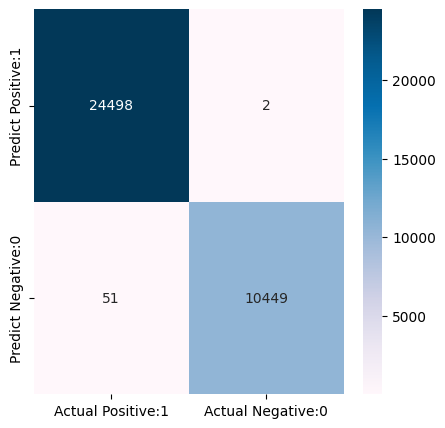

In [59]:
confusion_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

fig, ax = plt.subplots(figsize=(5,5)) 
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap = 'PuBu', ax = ax)

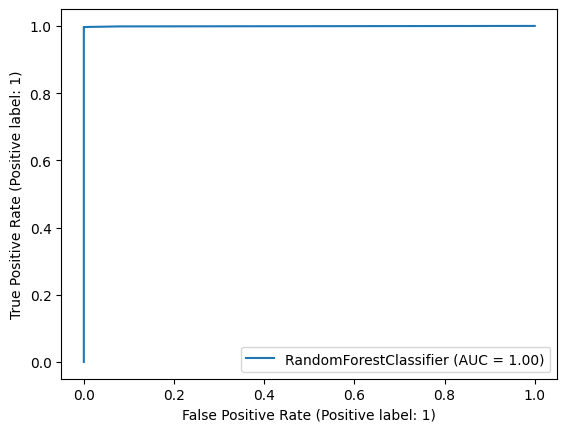

In [60]:
RocCurveDisplay.from_estimator(model, X_test_SMOTE70, y_test_SMOTE30)
plt.show()

## Modelling with SMOTE + XGBClassifier

### 50/50 Instantiate the XGBC Model

In [61]:
# Extreme Gradient Boosting algorithm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

modelXGBC = XGBClassifier()

modelXGBC.fit(X_train1, y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [62]:
y_pred_50XGBC = modelXGBC.predict(X_test_SMOTE50)

In [63]:
recall50XGBC = recall_score(y_test_SMOTE50, y_pred_50XGBC)
print("Recall:", recall50XGBC)

Recall: 0.9949142857142858


In [64]:
accuracy2 =accuracy_score(y_test_SMOTE50, y_pred_50XGBC)
print('XGBC Model accuracy: {0:0.4f}'.format(accuracy_score(y_test_SMOTE50, y_pred_50XGBC)))

XGBC Model accuracy: 0.9973


In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_SMOTE50, y_pred_50XGBC)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[17494     6]
 [   89 17411]]

True Positives(TP) =  17494

True Negatives(TN) =  17411

False Positives(FP) =  6

False Negatives(FN) =  89


<AxesSubplot:>

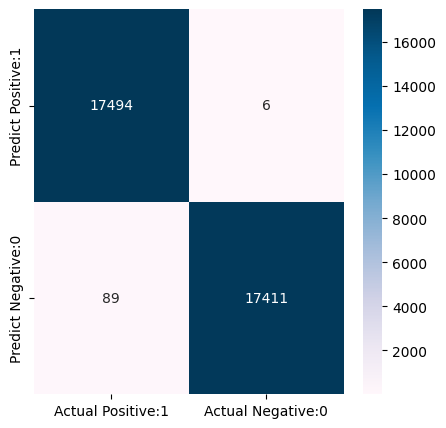

In [66]:
confusion_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

fig, ax = plt.subplots(figsize=(5,5)) 
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap = 'PuBu', ax = ax)

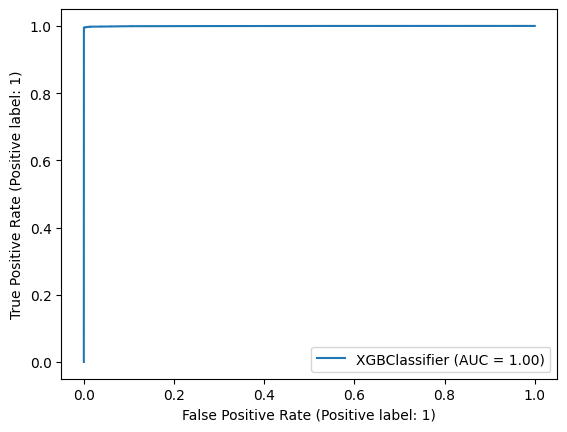

In [67]:
RocCurveDisplay.from_estimator(modelXGBC, X_test_SMOTE50, y_test_SMOTE50)
plt.show()

### 70/30 Instantiate the XGBC Model

In [68]:
y_pred_30XGBC = modelXGBC.predict(X_test_SMOTE70)

In [69]:
recall30XGBC = recall_score(y_test_SMOTE30, y_pred_30XGBC)
print("Recall:", recall30XGBC)

Recall: 0.9949523809523809


In [70]:
accuracy3 =accuracy_score(y_test_SMOTE30, y_pred_30XGBC)
print('XGBC Model accuracy: {0:0.4f}'.format(accuracy_score(y_test_SMOTE30, y_pred_30XGBC)))

XGBC Model accuracy: 0.9984


In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_SMOTE30, y_pred_30XGBC)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[24496     4]
 [   53 10447]]

True Positives(TP) =  24496

True Negatives(TN) =  10447

False Positives(FP) =  4

False Negatives(FN) =  53


<AxesSubplot:>

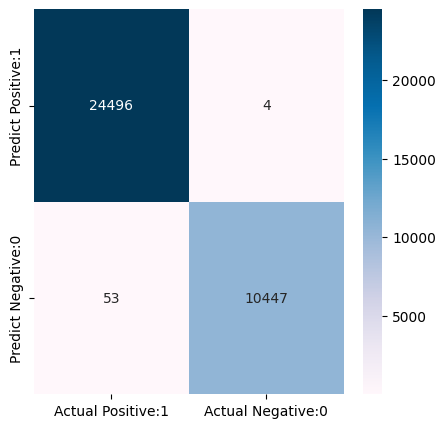

In [72]:
confusion_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

fig, ax = plt.subplots(figsize=(5,5)) 
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap = 'PuBu', ax = ax)

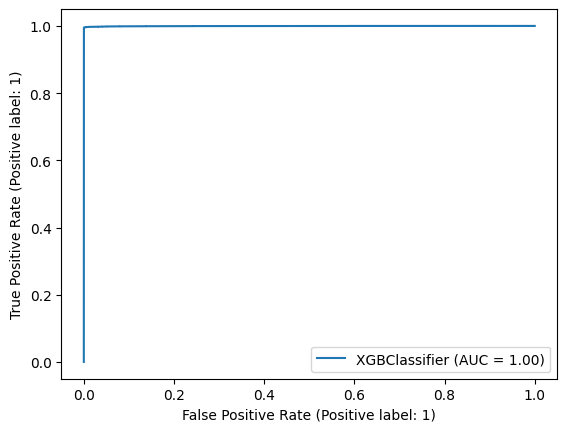

In [73]:
RocCurveDisplay.from_estimator(modelXGBC, X_test_SMOTE70, y_test_SMOTE30)
plt.show()

## Rebalancing with ADASYN

In [ ]:
X_resampled_ADASYN, y_resampled_ADASYN = ADASYN().fit_resample(X_train, y_train)

In [ ]:
X_resampled_ADASYN['isFraud'] = y_resampled_ADASYN

In [ ]:
#Check if data is balanced after ADASYN balancing
import matplotlib.pyplot as plt
labels = 'Not Fraud','Fraud'
values=X_resampled_ADASYN['isFraud'].value_counts()
fig, ax = plt.subplots()
ax.pie(values, labels=labels)

### Getting a sample

In [ ]:
fraud_A = X_resampled_ADASYN[X_resampled_ADASYN.isFraud == 1].sample(100000)
notfraud_A =X_resampled_ADASYN[X_resampled_ADASYN.isFraud == 0].sample(100000)

In [ ]:
data_new_A = pd.concat([fraud, notfraud], axis=0)

## Modelling with ADASYN

### Intantiate the Random Forest Classifier model

In [ ]:
X_train_A = data_new_A.drop('isFraud', axis = 1)
y_train_A = data_new_A['isFraud']

In [ ]:
model = RandomForestClassifier()

In [ ]:
model.fit(X_train_A, y_train_A)

In [ ]:
y_pred_A = model.predict(X_test)

### Score model on test data

In [ ]:
# Score the model on the Test data
recall_A = recall_score(y_test, y_pred)
print("Recall:", recall)

## Feature Importance

### SMOTE

### 50/50 RFC

In [ ]:
from sklearn.inspection import permutation_importance
RFC_model50 = RandomForestClassifier().fit(X_train1, y_train1) # Fit model
permutation_score = permutation_importance(RFC_model50, X_train1, y_train1, n_repeats=10, scoring = 'recall') # Perform Permutation"
importance_df50 = pd.DataFrame(np.vstack((X.columns, permutation_score.importances_mean)).T) # Unstack results"
importance_df50.columns=['feature','score_decrease']
importance_df50.sort_values(by='score_decrease', ascending = False) # Order by importance"

### 50/50 XGBC

In [ ]:
XGBC_model = XGBClassifier().fit(X_train1, y_train1) # Fit model
permutation_score = permutation_importance(XGBC_model, X_train1, y_train1, n_repeats=10, scoring = 'recall') # Perform Permutation"
importance_xgbc = pd.DataFrame(np.vstack((X.columns, permutation_score.importances_mean)).T) # Unstack results"
importance_xgbc.columns=['feature','score_decrease']
importance_xgbc.sort_values(by='score_decrease', ascending = False) # Order by importance"

### ADYSN

In [ ]:
RFC_model = RandomForestClassifier().fit(X_train1, y_train1) # Fit model
permutation_score = permutation_importance(RFC_model, X_train_A, y_train_A, n_repeats=10, scoring = 'recall') # Perform Permutation"
importance_df = pd.DataFrame(np.vstack((X.columns, permutation_score.importances_mean)).T) # Unstack results"
importance_df.columns=['feature','score_decrease']
importance_df.sort_values(by='score_decrease', ascending = False) # Order by importance"